# Plot posterior estimates 

This notebook is for plotting parameter values and tree metrics taken from the posterior rather than the summary tree

In [1]:
import glob
import re,copy, imp
import pandas as pd 
import numpy as np

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '/Users/lmoncla/src/baltic/baltic/baltic.py')

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

import rpy2
%load_ext rpy2.ipython

In [2]:
from datetime import date
current_date = str(date.today())

In [3]:
# define colors 
domestic_color="#4E83AE"
wild_color="#CEB540"
human_color="#DE4428"

In [4]:
def read_in_migration_rates_mtt(log_file_path):
    
    mig_rates_dict = {"sample":[]}
    
    with open(log_file_path, "r") as infile:
        for line in infile:
            
            # use the first line to find the migration rate columns
            if "posterior" in line:
                all_cols = line.split("\t")
                migration_column_indices = []   # list to store column indices
                mig_rates_key = {}   # dictionary to store the column index to map to column name
                
                for i in range(len(all_cols)):
                    col = all_cols[i]
                    if ".rateMatrix_" in col:
                        migration_column_indices.append(i)

                # make an empty dictionary to store migration rates and generate dictionary to convert index to name
                for m in migration_column_indices:
                    name = line.split("\t")[m]
                    mig_rates_key[m] = name
                    mig_rates_dict[name] = []
                
            # read in actual parameter estimates and store in dictionary
            else:
                sample = line.split("\t")[0]
                mig_rates_dict["sample"].append(sample)
                
                for index in migration_column_indices:
                    name = mig_rates_key[index]
                    mig_rates_dict[name].append(line.split("\t")[index])
                    
                
    return(mig_rates_dict)

In [5]:
def read_in_migration_rates_mascot(log_file_path):
    
    mig_rates_dict = {"sample":[]}
    
    with open(log_file_path, "r") as infile:
        line_number = 0
        for line in infile:
            line_number += 1
            if not line.startswith("#"):  # log combiner will sometimes put the entire xml at the start of the log file
                # use the first line to find the migration rate columns
                
                if "sample" in line.lower():
                    all_cols = line.split("\t")
                    migration_column_indices = []   # list to store column indices
                    mig_rates_key = {}   # dictionary to store the column index to map to column name

                    for i in range(len(all_cols)):
                        col = all_cols[i]
                        if "_migration" in col:
                            migration_column_indices.append(i)

                    # make an empty dictionary to store migration rates and generate dictionary to convert index to name
                    for m in migration_column_indices:
                        name = line.split("\t")[m]
                        mig_rates_key[m] = name
                        mig_rates_dict[name] = []
                    
                # read in actual parameter estimates and store in dictionary
                else:
                    sample = line.split("\t")[0]
                    mig_rates_dict["sample"].append(sample)

                    for index in migration_column_indices:
                        name = mig_rates_key[index]
                        mig_rates_dict[name].append(line.split("\t")[index])
                    
                
    return(mig_rates_dict)

In [6]:
# log file paths
constant_human_on = {"label": "constant-human-on","mig_direction":"backwards in time",
    "log":"beast-runs/2021-03-15-mascot-3deme-constant/with-human-mig/3deme-mascot-constant-with-human-mig-2021-03-15.combined.log"}
constant_human_off = {"label": "constant-human-off","mig_direction":"backwards in time",
    "log":"beast-runs/2021-03-15-mascot-3deme-constant/no-human-mig/3deme-mascot-constant-no-human-mig-2021-03-15.combined.log"}
skyline_human_on =  {"label": "skyline-human-on", "mig_direction":"forwards in time",
                     "log": "beast-runs/2021-03-15-mascot-3deme-skyline-with-mig-history/with-human-mig/2021-04-27-mascot-3deme-skyline-with-human-mig.combined.log"}
skyline_human_off = {"label": "skyline-human-off", "mig_direction":"forwards in time",
                     "log": "beast-runs/2021-03-15-mascot-3deme-skyline-with-mig-history/no-human-mig-2021-03-31/2021-04-27-mascot-3deme-no-human-mig.combined.log"}

In [7]:
to_run = skyline_human_off

log_file_path = to_run['log']
label = to_run['label']
mig_direction = to_run['mig_direction']

burnin_percent = 0.0

migration_rates = read_in_migration_rates_mascot(log_file_path)

In [8]:
mig_df = pd.DataFrame.from_dict(migration_rates)
print(len(mig_df))

rows_to_remove = int(len(mig_df)* burnin_percent)
mig_df = mig_df.iloc[rows_to_remove:]

print(len(mig_df))
mig_df.head()

17015
17015


,sample,f_migration.domestic_to_human,f_migration.domestic_to_wild,f_migration.human_to_domestic,f_migration.human_to_wild,f_migration.wild_to_domestic,f_migration.wild_to_human
0,0,0.48059397058015163,0.0820546066498072,0.0,0.0,0.997603891509906,0.009952812321237039
1,10000,0.4462602059090131,0.08752504858484249,0.0,0.0,0.7829142399867374,0.011629117392762392
2,20000,0.4915452390163455,0.04670750252120371,0.0,0.0,1.1071487044727624,0.024759367803582448
3,30000,0.4576390590990702,0.05697681319806374,0.0,0.0,0.7137097412798245,9.844874893188242E-4
4,40000,0.6225515848936511,0.030982751245719687,0.0,0.0,1.1135205024292194,0.02825235934062323


In [9]:
mig_df_melted = mig_df.melt(id_vars = ['sample'])
mig_df_melted['variable'] = mig_df_melted['variable'].str.replace("f_migration.","").str.replace("b_migration.","")
#mig_df_melted['variable'] = mig_df_melted['variable'].str.replace("migModel.t:mtt-3-deme-4-rates-hot-chain-2020-11-05-it1.rateMatrix_","")
#mig_df_melted['variable'] = mig_df_melted['variable'].str.replace("_","_to_")

mig_df_melted.head()

,sample,variable,value
0,0,domestic_to_human,0.48059397058015163
1,10000,domestic_to_human,0.4462602059090131
2,20000,domestic_to_human,0.4915452390163455
3,30000,domestic_to_human,0.4576390590990702
4,40000,domestic_to_human,0.6225515848936511


In [10]:
# define colors 
domestic_to_human="#4E83AE"
domestic_to_wild="#90B2C4"

wild_to_domestic="#CEB540"
wild_to_human="#E0D188"

human_to_domestic="#DE4428"
human_to_wild="#EA8A79"

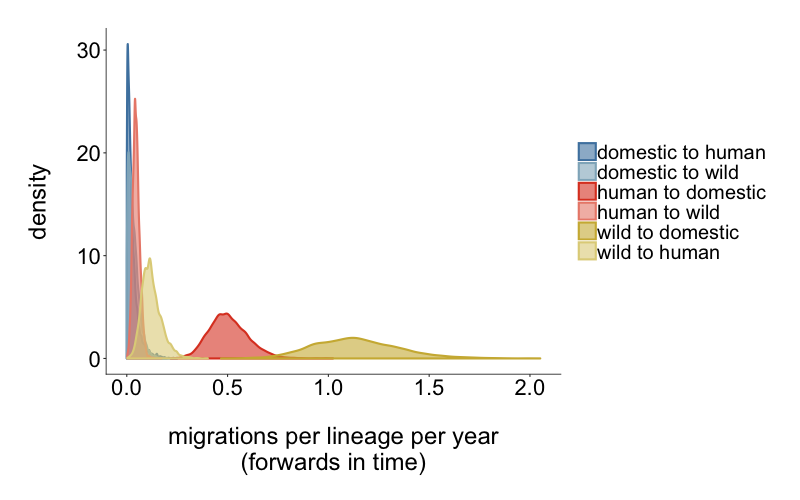

In [166]:
%%R -w 800 -h 500 -u px -i current_date,label,mig_direction,mig_df_melted,domestic_to_human,domestic_to_wild,wild_to_domestic,wild_to_human,human_to_wild,human_to_domestic # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("migration-rates-",label,"-",current_date,".pdf", sep="")
#output_filename = paste("migration-rates-mtt-3deme-4rates-2020-11-05.pdf", sep="")

mig_df_melted$value = as.numeric(mig_df_melted$value)

p <- ggplot(data=mig_df_melted, aes(x=value, group=variable, color=variable, fill=variable)) + 
    geom_density(data=mig_df_melted, aes(x=value, group=variable, color=variable, fill=variable), trim=TRUE, alpha=0.6, linetype="solid",size=1)+
    labs(x=paste("\nmigrations per lineage per year\n(",mig_direction,")",sep=""),y="density\n")+
     scale_color_manual(values=c(domestic_to_human=domestic_to_human,domestic_to_wild=domestic_to_wild,wild_to_domestic=wild_to_domestic,wild_to_human=wild_to_human,human_to_domestic=human_to_domestic,human_to_wild=human_to_wild), labels=c(domestic_to_human="domestic to human", domestic_to_wild = "domestic to wild", human_to_domestic = "human to domestic", human_to_wild = "human to wild", wild_to_domestic="wild to domestic", wild_to_human = "wild to human"))+
     scale_fill_manual(values=c(domestic_to_human=domestic_to_human,domestic_to_wild=domestic_to_wild,wild_to_domestic=wild_to_domestic,wild_to_human=wild_to_human,human_to_domestic=human_to_domestic,human_to_wild=human_to_wild), labels=c(domestic_to_human="domestic to human", domestic_to_wild = "domestic to wild", human_to_domestic = "human to domestic", human_to_wild = "human to wild", wild_to_domestic="wild to domestic", wild_to_human = "wild to human"))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
#     scale_x_continuous(breaks=seq(0,3,1), limits=c(0,3))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

# Plot estimated Ne over time

Since allowing for Ne changes over time appears to be critical to this working, I want to see what is being estimated

In [11]:
def read_in_Ne_changes_mascot(log_file_path):
    
    Ne_skyline_dict = {"sample":[]}
    
    with open(log_file_path, "r") as infile:
        for line in infile:
            
            # use the first line to find the migration rate columns
            if "posterior" in line:
                all_cols = line.split("\t")
                Ne_column_indices = []   # list to store column indices
                Nes_key = {}   # dictionary to store the column index to map to column name
                
                for i in range(len(all_cols)):
                    col = all_cols[i]
                    if "NeLog.state" in col:
                        Ne_column_indices.append(i)
                
                # make an empty dictionary to store Nes and generate dictionary to convert index to name
                for n in Ne_column_indices:
                    name = line.split("\t")[n]
                    deme = name.split(".state")[1][0]   # the syntax here is "NeLog.state01" where 0 is deme and 1 is interval 1
                    interval = name.split(".state")[1][1]
                    Nes_key[n] = name
                    Ne_skyline_dict[name] = []

                
            # read in actual parameter estimates and store in dictionary
            else:
                sample = line.split("\t")[0]
                Ne_skyline_dict["sample"].append(sample)
                
                for index in Ne_column_indices:
                    name = Nes_key[index]
                    Ne_skyline_dict[name].append(line.split("\t")[index])
                    
                
    return(Ne_skyline_dict)

In [12]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each deme and interval 
def generate_summary_df(input_df):
    
    import pymc3
    new_df = pd.DataFrame()

    for i in input_df.columns.tolist():
        if "NeLog" in i:
            deme = i.split("_")[1]
            interval = i.split("_")[2]
            local_series = Ne_df[i].astype(float)
            mean_log = local_series.mean()
            mean_linear = 10**mean_log
            hpd = pymc3.stats.hpd(local_series, 0.95)
            lower_hpd_log = hpd[0]
            lower_hpd_linear = 10**lower_hpd_log
            upper_hpd_log = hpd[1]
            upper_hpd_linear = 10**upper_hpd_log

            local_df = pd.DataFrame.from_dict({"deme":deme, "interval":interval, "mean_Ne_log":mean_log,"mean_Ne_linear":mean_linear, 
                                               "upper_hpd_log":upper_hpd_log,"lower_hpd_log":[lower_hpd_log], 
                                               "upper_hpd_linear":upper_hpd_linear,"lower_hpd_linear":lower_hpd_linear})

            new_df = new_df.append(local_df)
            
    return(new_df)

In [13]:
Ne_skyline = read_in_Ne_changes_mascot(log_file_path)

In [14]:
Ne_df = pd.DataFrame.from_dict(Ne_skyline)
print(len(Ne_df))
Ne_df.head()

17015


,sample,NeLog.state01,NeLog.state02,NeLog.state03,NeLog.state04,NeLog.state05,NeLog.state06,NeLog.state07,NeLog.state08,NeLog.state09,...,NeLog.state252,NeLog.state253,NeLog.state254,NeLog.state255,NeLog.state256,NeLog.state257,NeLog.state258,NeLog.state259,NeLog.state260,NeLog.state261
0,0,-0.19915876269797433,0.07261918069541362,-0.02997947949888182,1.1931284520154242,1.4827071479169553,1.7520439066878701,2.2660386591189696,2.121340311899664,2.1823097309949415,...,-0.5376596094695408,-0.6473185844577928,-0.8239984928372276,-1.0227670257052015,-1.2710816228601396,-1.6512047666002079,-1.109362871213788,-0.7976323863076475,-0.02834425012460831,-0.18799668431958438
1,10000,0.4565977931416795,0.5848133324490251,0.39066291286546406,0.3111835603912917,0.5201246529267293,1.177015011971976,1.6596455331244198,1.70596981804056,2.356415639928096,...,-0.05558982854389975,0.0819376145023077,-0.11089270645950451,-0.30636401812068786,-0.709458463002822,-0.8653731433611723,-1.311144519622599,-0.2838806914767177,-4.105351185849258E-4,-0.15330588088761551
2,20000,1.114680896807768,1.1953071412110512,1.3272589701457227,1.2945137357636523,1.7376715490664594,1.7441036604632594,1.5822041374034201,1.5676941944251006,1.3918592175650575,...,0.8194000124592214,-0.22149486085659914,0.19291796609375256,0.3878647352879851,0.37889802300353764,-0.02214064843870273,-0.8949803175662204,-0.29823076565534395,-0.024805381994954145,-0.29864609380501583
3,30000,0.0010020399045838624,-0.16603725844656975,-0.22922386839662576,0.4804835404437055,0.6806495483521979,1.1256156869988871,1.393998031368679,1.2889868135133522,1.5500660316885297,...,0.5439811985009007,0.35895216942126645,0.5114918980608103,0.4132772939299558,0.020636609563148306,-0.636932999390431,-1.1908375012992447,-0.5755500708096746,-0.6538095120601377,0.12307320255375075
4,40000,-0.052383183046136095,-0.2413474677943465,0.22597087296016038,1.3976252179821933,1.889673845582535,2.136558810841736,2.1448039645706305,1.113551042578951,1.0414404784813198,...,0.5202803138403828,0.7648678658325095,0.3553291195998152,1.3371288280134477,1.2996010877144255,1.4000748512361925,1.7669514938614093,2.336929573698039,1.1729889649026657,1.0291730673266717


In [15]:
Ne_df.columns = Ne_df.columns.str.replace(".state0", "_domestic_")
Ne_df.columns = Ne_df.columns.str.replace(".state1", "_human_")
Ne_df.columns = Ne_df.columns.str.replace(".state2", "_wild_")
Ne_df.head()

,sample,NeLog_domestic_1,NeLog_domestic_2,NeLog_domestic_3,NeLog_domestic_4,NeLog_domestic_5,NeLog_domestic_6,NeLog_domestic_7,NeLog_domestic_8,NeLog_domestic_9,...,NeLog_wild_52,NeLog_wild_53,NeLog_wild_54,NeLog_wild_55,NeLog_wild_56,NeLog_wild_57,NeLog_wild_58,NeLog_wild_59,NeLog_wild_60,NeLog_wild_61
0,0,-0.19915876269797433,0.07261918069541362,-0.02997947949888182,1.1931284520154242,1.4827071479169553,1.7520439066878701,2.2660386591189696,2.121340311899664,2.1823097309949415,...,-0.5376596094695408,-0.6473185844577928,-0.8239984928372276,-1.0227670257052015,-1.2710816228601396,-1.6512047666002079,-1.109362871213788,-0.7976323863076475,-0.02834425012460831,-0.18799668431958438
1,10000,0.4565977931416795,0.5848133324490251,0.39066291286546406,0.3111835603912917,0.5201246529267293,1.177015011971976,1.6596455331244198,1.70596981804056,2.356415639928096,...,-0.05558982854389975,0.0819376145023077,-0.11089270645950451,-0.30636401812068786,-0.709458463002822,-0.8653731433611723,-1.311144519622599,-0.2838806914767177,-4.105351185849258E-4,-0.15330588088761551
2,20000,1.114680896807768,1.1953071412110512,1.3272589701457227,1.2945137357636523,1.7376715490664594,1.7441036604632594,1.5822041374034201,1.5676941944251006,1.3918592175650575,...,0.8194000124592214,-0.22149486085659914,0.19291796609375256,0.3878647352879851,0.37889802300353764,-0.02214064843870273,-0.8949803175662204,-0.29823076565534395,-0.024805381994954145,-0.29864609380501583
3,30000,0.0010020399045838624,-0.16603725844656975,-0.22922386839662576,0.4804835404437055,0.6806495483521979,1.1256156869988871,1.393998031368679,1.2889868135133522,1.5500660316885297,...,0.5439811985009007,0.35895216942126645,0.5114918980608103,0.4132772939299558,0.020636609563148306,-0.636932999390431,-1.1908375012992447,-0.5755500708096746,-0.6538095120601377,0.12307320255375075
4,40000,-0.052383183046136095,-0.2413474677943465,0.22597087296016038,1.3976252179821933,1.889673845582535,2.136558810841736,2.1448039645706305,1.113551042578951,1.0414404784813198,...,0.5202803138403828,0.7648678658325095,0.3553291195998152,1.3371288280134477,1.2996010877144255,1.4000748512361925,1.7669514938614093,2.336929573698039,1.1729889649026657,1.0291730673266717


In [16]:
Ne_summary = generate_summary_df(Ne_df)
Ne_summary.head()

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear
0,domestic,1,1.403996,25.351080,3.272587,-0.550332,1873.214343,0.281623
0,domestic,2,1.478266,30.079193,3.321505,-0.356504,2096.548808,0.440044
0,domestic,3,1.535536,34.319133,3.138003,-0.290433,1374.051493,0.512350
0,domestic,4,1.609645,40.704696,3.160740,0.030646,1447.905775,1.073113
0,domestic,5,1.676624,47.492375,3.052099,0.175607,1127.453610,1.498329


### add in dates and convert the interval into something more interpretable

I estimated 60 intervals, 2 per year for a 30 year tree. So interval 1 is 0.5 years backwards in time, and interval 60 is 30 years back in time. The most recent tips I have are in 2019, with an exact date of 2019.227. According to this tutorial, and the fact that Nicola's software has skygrid in it rather than skyline, I am pretty sure that the times here represent back in by year from date of youngest tip. 

In [17]:
Ne_summary['years_from_present'] = Ne_summary['interval'].astype(float)/2
Ne_summary['date'] = 2019.227 - Ne_summary['years_from_present']
Ne_summary.head()

,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear,years_from_present,date
0,domestic,1,1.403996,25.351080,3.272587,-0.550332,1873.214343,0.281623,0.5,2018.727
0,domestic,2,1.478266,30.079193,3.321505,-0.356504,2096.548808,0.440044,1.0,2018.227
0,domestic,3,1.535536,34.319133,3.138003,-0.290433,1374.051493,0.512350,1.5,2017.727
0,domestic,4,1.609645,40.704696,3.160740,0.030646,1447.905775,1.073113,2.0,2017.227
0,domestic,5,1.676624,47.492375,3.052099,0.175607,1127.453610,1.498329,2.5,2016.727


## Read in human case data

I have case data from all human infections with H5N1 from 2003 to 2020 from the [WHO](https://www.who.int/influenza/human_animal_interface/H5N1_cumulative_table_archives/en/)

In [18]:
human_cases = "H5N1_cumulative_case_counts_country_2003-2020.txt"

human_cases_dict = {}

with open(human_cases, "r") as infile: 
    for line in infile: 
        if "cases" not in line: 
            country = line.split("\t")[0]
            cases = int(line.split("\t")[1])
            deaths = line.split("\t")[2]
            year = line.split("\t")[3].strip()
            
            if year not in human_cases_dict:
                human_cases_dict[year] = cases
            else: 
                human_cases_dict[year] += cases

In [19]:
human_cases_df = pd.DataFrame(human_cases_dict, index=['cases']).transpose()
human_cases_df.reset_index(inplace=True)
human_cases_df.columns = ['year','cases']
human_cases_df

,year,cases
0,2003,4
1,2004,46
2,2005,98
3,2006,115
4,2007,88
5,2008,44
6,2009,73
7,2010,48
8,2011,62
9,2012,32


In [20]:
mean = human_cases_df['cases'].mean()
std = human_cases_df['cases'].std()
human_cases_df['standardized_cases'] = (human_cases_df['cases'] - mean)/std
human_cases_df.head()

,year,cases,standardized_cases
0,2003,4,-1.023987
1,2004,46,-0.044070
2,2005,98,1.169160
3,2006,115,1.565793
4,2007,88,0.935847


In [21]:
mean_Ne = Ne_summary['mean_Ne_log'].mean()
std_Ne = Ne_summary['mean_Ne_log'].std()
Ne_summary['standardized_log_Ne'] = (Ne_summary['mean_Ne_log'] - mean_Ne)/std_Ne
Ne_summary['standardized_lower_hpd_log'] = (Ne_summary['lower_hpd_log'] - Ne_summary['lower_hpd_log'].mean())/Ne_summary['lower_hpd_log'].std()
Ne_summary['standardized_upper_hpd_log'] = (Ne_summary['upper_hpd_log'] - Ne_summary['upper_hpd_log'].mean())/Ne_summary['upper_hpd_log'].std()

Ne_summary.head()

,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear,years_from_present,date,standardized_log_Ne,standardized_lower_hpd_log,standardized_upper_hpd_log
0,domestic,1,1.403996,25.351080,3.272587,-0.550332,1873.214343,0.281623,0.5,2018.727,0.138115,-0.200068,0.953788
0,domestic,2,1.478266,30.079193,3.321505,-0.356504,2096.548808,0.440044,1.0,2018.227,0.202212,-0.092389,1.022304
0,domestic,3,1.535536,34.319133,3.138003,-0.290433,1374.051493,0.512350,1.5,2017.727,0.251637,-0.055685,0.765283
0,domestic,4,1.609645,40.704696,3.160740,0.030646,1447.905775,1.073113,2.0,2017.227,0.315594,0.122686,0.797130
0,domestic,5,1.676624,47.492375,3.052099,0.175607,1127.453610,1.498329,2.5,2016.727,0.373399,0.203217,0.644961


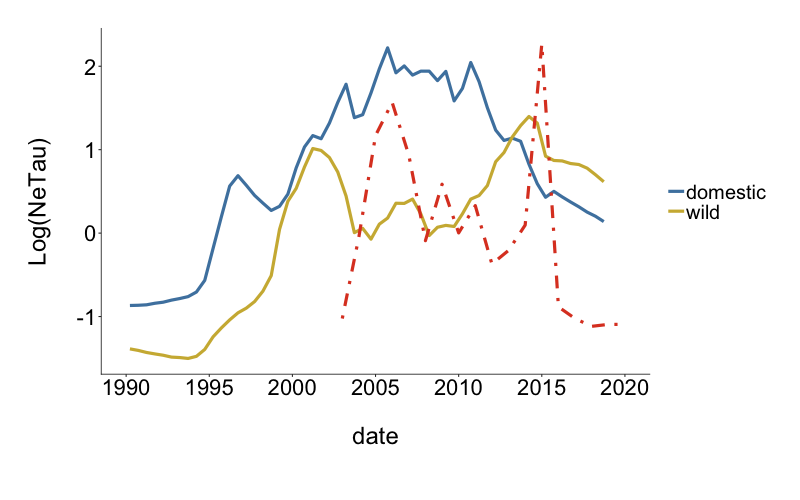

In [242]:
%%R -w 800 -h 500 -u px -i human_cases_df,current_date,label,Ne_summary,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)
require(grid)
library(grid)
require(gridExtra)
library(gridExtra)


output_filename = paste("NeTau-log-with-cases-",label,"-",current_date,".pdf", sep="")

Ne_summary$interval = as.numeric(Ne_summary$interval)
human_cases_df$year = as.numeric(human_cases_df$year)

# optionally, remove human 
Ne_summary <- Ne_summary[!(Ne_summary$deme=="human"),]

p1 <- ggplot() + 
    geom_line(data=Ne_summary, aes(x=date, y=standardized_log_Ne,group=deme, color=deme, fill=deme), size=1.5)+
#     geom_ribbon(data=Ne_summary, aes(x=date, ymin = standardized_lower_hpd_log, ymax = standardized_upper_hpd_log,fill = Ne_summary$deme,group=Ne_summary$deme), alpha=0.5) +
    geom_line(data=human_cases_df, aes(x=year, y=standardized_cases), color=human_color, linetype=4, size=1.5)+
    labs(x="\ndate\n",y="Log(NeTau)\n")+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1

In [65]:
Ne_summary.head()

,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear,years_from_present,date,standardized_log_Ne,standardized_lower_hpd_log,standardized_upper_hpd_log,year
0,domestic,1,1.403996,25.351080,3.272587,-0.550332,1873.214343,0.281623,0.5,2018.727,0.138115,-0.200068,0.953788,2018
0,domestic,2,1.478266,30.079193,3.321505,-0.356504,2096.548808,0.440044,1.0,2018.227,0.202212,-0.092389,1.022304,2018
0,domestic,3,1.535536,34.319133,3.138003,-0.290433,1374.051493,0.512350,1.5,2017.727,0.251637,-0.055685,0.765283,2017
0,domestic,4,1.609645,40.704696,3.160740,0.030646,1447.905775,1.073113,2.0,2017.227,0.315594,0.122686,0.797130,2017
0,domestic,5,1.676624,47.492375,3.052099,0.175607,1127.453610,1.498329,2.5,2016.727,0.373399,0.203217,0.644961,2016


In [75]:
Ne_summary_d = Ne_summary[Ne_summary['deme'] == 'domestic']
Ne_summary_d = Ne_summary_d[['deme','mean_Ne_log','date']]
Ne_summary_w = Ne_summary[Ne_summary['deme'] == 'wild']
Ne_summary_w = Ne_summary_w[['deme','mean_Ne_log','date']]
Ne_summary_wd = Ne_summary_d.merge(Ne_summary_w, on="date")

Ne_summary_wd.head()

,deme_x,mean_Ne_log_x,date,deme_y,mean_Ne_log_y
0,domestic,1.403996,2018.727,wild,1.957262
1,domestic,1.478266,2018.227,wild,2.055111
2,domestic,1.535536,2017.727,wild,2.145611
3,domestic,1.609645,2017.227,wild,2.196548
4,domestic,1.676624,2016.727,wild,2.210584


In [84]:
print(min(Ne_summary_wd['mean_Ne_log_x']))
print(min(Ne_summary_wd['mean_Ne_log_y']))

0.21003728499758345
-0.4966731336165364


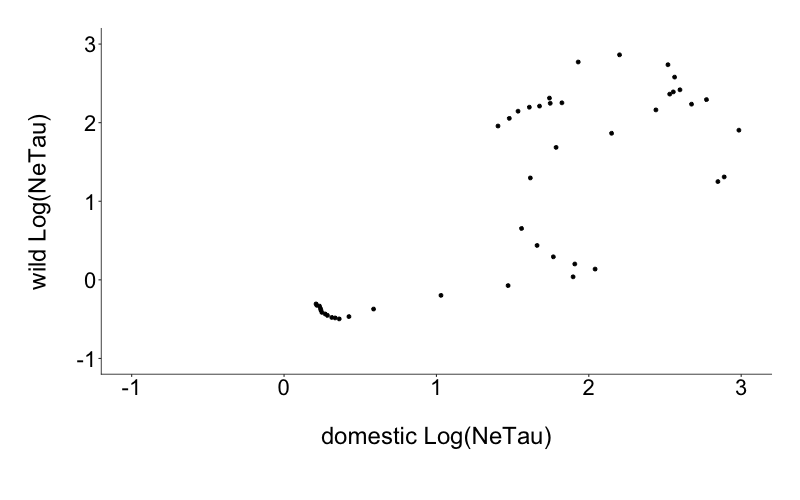

In [86]:
%%R -w 800 -h 500 -u px -i current_date,label,Ne_summary_wd,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("domestic-vs-wild-NeTau-",label,"-",current_date,".pdf", sep="")

p1 <- ggplot(data=Ne_summary_wd, aes(x=mean_Ne_log_x, y=mean_Ne_log_y)) + 
    geom_point(size=1.5)+
    labs(x="\ndomestic Log(NeTau)\n",y="wild Log(NeTau)\n")+
    scale_x_continuous(breaks=seq(-1,3,1), limits=c(-1,3), labels=c(-1,0,1,2,3))+
    scale_y_continuous(breaks=seq(-1,3,1), limits=c(-1,3), labels=c(-1,0,1,2,3))+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1

### try plotting correlation between Ne and human cases

In [25]:
def return_year(decimal_date):
    year = str(decimal_date).split(".")[0]
    return(year)

In [27]:
Ne_summary['year'] = Ne_summary['date'].apply(return_year)

In [33]:
# now, merge in dataframes
Ne_and_cases = Ne_summary.merge(human_cases_df, on="year")
Ne_and_cases.head()

,deme,interval,mean_Ne_log,mean_Ne_linear,upper_hpd_log,lower_hpd_log,upper_hpd_linear,lower_hpd_linear,years_from_present,date,standardized_log_Ne,standardized_lower_hpd_log,standardized_upper_hpd_log,year,cases,standardized_cases
0,domestic,1,1.403996,25.351080,3.272587,-0.550332,1873.214343,0.281623,0.5,2018.727,0.138115,-0.200068,0.953788,2018,0,-1.117313
1,domestic,2,1.478266,30.079193,3.321505,-0.356504,2096.548808,0.440044,1.0,2018.227,0.202212,-0.092389,1.022304,2018,0,-1.117313
2,human,1,-0.002370,0.994558,2.206145,-2.371543,160.747863,0.004251,0.5,2018.727,-1.075611,-1.211815,-0.539920,2018,0,-1.117313
3,human,2,0.004019,1.009297,2.259486,-2.150848,181.755055,0.007066,1.0,2018.227,-1.070097,-1.089211,-0.465208,2018,0,-1.117313
4,wild,1,1.957262,90.627843,3.878485,0.025496,7559.351565,1.060463,0.5,2018.727,0.615596,0.119825,1.802435,2018,0,-1.117313


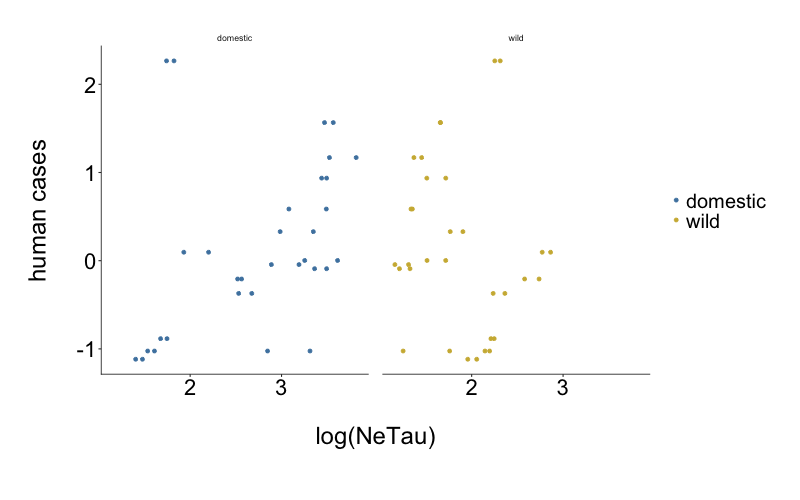

In [40]:
%%R -w 800 -h 500 -u px -i Ne_and_cases,current_date,label,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("NeTau-log-vs-cases-",label,"-",current_date,".pdf", sep="")

Ne_and_cases$interval = as.numeric(Ne_and_cases$interval)
Ne_and_cases$year = as.numeric(Ne_and_cases$year)

reg1 <- lm(mean_Ne_log~standardized_cases,data=hsb2) 
summary(reg1)

# optionally, remove human 
Ne_and_cases <- Ne_and_cases[!(Ne_and_cases$deme=="human"),]

p1 <- ggplot() + 
    geom_point(data=Ne_and_cases, aes(x=mean_Ne_log, y=standardized_cases,group=deme, color=deme, fill=deme), size=1.5)+
    facet_wrap(~deme)+
    labs(x="\nlog(NeTau)\n",y="human cases\n")+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    #scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1


Call:
lm(formula = mean_Ne_log ~ standardized_cases, data = Ne_and_cases)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6570 -0.6914  0.2051  0.5195  0.9339 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)          2.6952     0.1307   20.62   <2e-16 ***
standardized_cases   0.3105     0.1368    2.27   0.0306 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7318 on 30 degrees of freedom
Multiple R-squared:  0.1466,	Adjusted R-squared:  0.1181 
F-statistic: 5.153 on 1 and 30 DF,  p-value: 0.03056



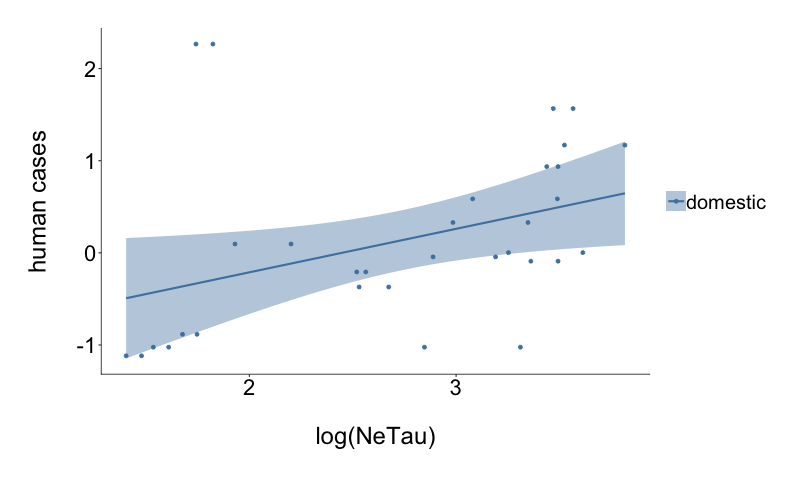

In [53]:
%%R -w 800 -h 500 -u px -i Ne_and_cases,current_date,label,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("domestic-NeTau-log-vs-cases-",label,"-",current_date,".pdf", sep="")

Ne_and_cases$interval = as.numeric(Ne_and_cases$interval)
Ne_and_cases$year = as.numeric(Ne_and_cases$year)

# optionally, just do domestic 
Ne_and_cases <- Ne_and_cases[(Ne_and_cases$deme=="domestic"),]

reg1 <- lm(mean_Ne_log~standardized_cases,data=Ne_and_cases) 
print(summary(reg1))

p1 <- ggplot(data=Ne_and_cases, aes(x=mean_Ne_log, y=standardized_cases,group=deme, color=deme, fill=deme)) + 
    geom_point(size=1.5)+
    labs(x="\nlog(NeTau)\n",y="human cases\n")+
    geom_smooth(method='lm')+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    #scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1


Call:
lm(formula = mean_Ne_log ~ standardized_cases, data = Ne_and_cases)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.72493 -0.38420 -0.09396  0.30645  0.98892 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1.88151    0.08894   21.16   <2e-16 ***
standardized_cases -0.07352    0.09308   -0.79    0.436    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4979 on 30 degrees of freedom
Multiple R-squared:  0.02037,	Adjusted R-squared:  -0.01228 
F-statistic: 0.6238 on 1 and 30 DF,  p-value: 0.4358



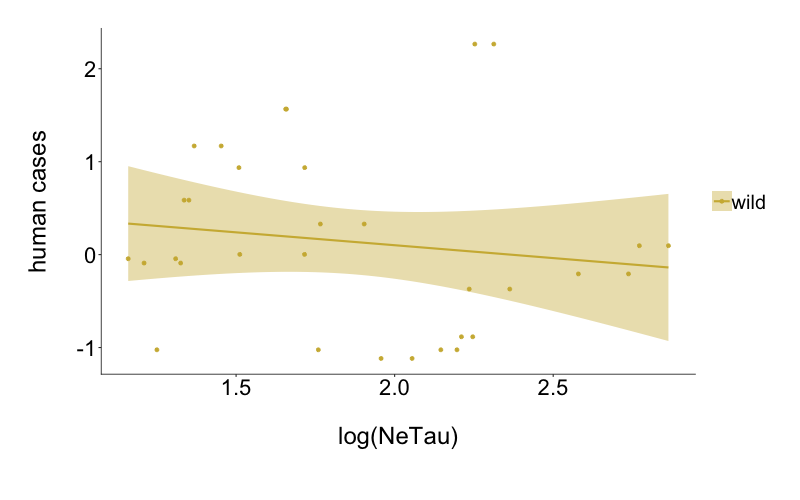

In [54]:
%%R -w 800 -h 500 -u px -i Ne_and_cases,current_date,label,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("wild-NeTau-log-vs-cases-",label,"-",current_date,".pdf", sep="")

Ne_and_cases$interval = as.numeric(Ne_and_cases$interval)
Ne_and_cases$year = as.numeric(Ne_and_cases$year)

# optionally, just do domestic 
Ne_and_cases <- Ne_and_cases[(Ne_and_cases$deme=="wild"),]

reg1 <- lm(mean_Ne_log~standardized_cases,data=Ne_and_cases) 
print(summary(reg1))

p1 <- ggplot(data=Ne_and_cases, aes(x=mean_Ne_log, y=standardized_cases,group=deme, color=deme, fill=deme)) + 
    geom_point(size=1.5)+
    labs(x="\nlog(NeTau)\n",y="human cases\n")+
    geom_smooth(method='lm')+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    #scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1


Call:
lm(formula = mean_Ne_log ~ standardized_cases, data = Ne_and_cases)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.42671 -0.47129 -0.07496  0.54942  1.01024 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)          0.7429     0.1147   6.476 3.71e-07 ***
standardized_cases   0.3851     0.1201   3.207  0.00318 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6422 on 30 degrees of freedom
Multiple R-squared:  0.2553,	Adjusted R-squared:  0.2305 
F-statistic: 10.29 on 1 and 30 DF,  p-value: 0.003177



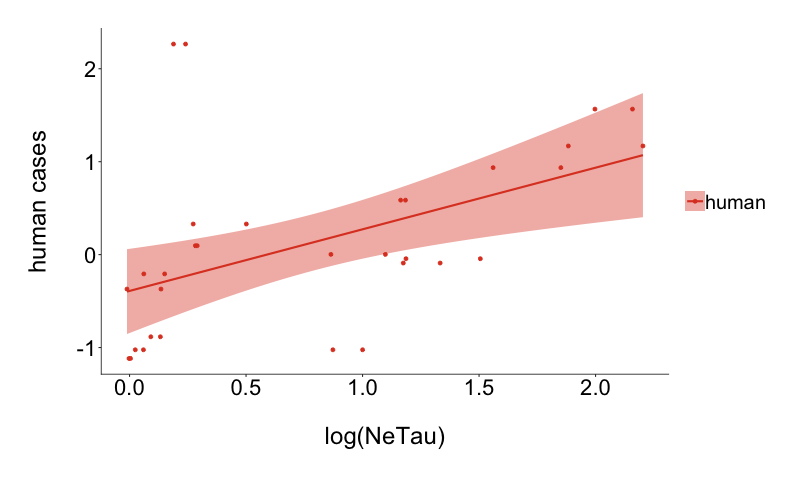

In [55]:
%%R -w 800 -h 500 -u px -i Ne_and_cases,current_date,label,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)


output_filename = paste("human-NeTau-log-vs-cases-",label,"-",current_date,".pdf", sep="")

Ne_and_cases$interval = as.numeric(Ne_and_cases$interval)
Ne_and_cases$year = as.numeric(Ne_and_cases$year)

# optionally, just do domestic 
Ne_and_cases <- Ne_and_cases[(Ne_and_cases$deme=="human"),]

reg1 <- lm(mean_Ne_log~standardized_cases,data=Ne_and_cases) 
print(summary(reg1))

p1 <- ggplot(data=Ne_and_cases, aes(x=mean_Ne_log, y=standardized_cases,group=deme, color=deme, fill=deme)) + 
    geom_point(size=1.5)+
    labs(x="\nlog(NeTau)\n",y="human cases\n")+
    geom_smooth(method='lm')+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    #scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p1, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p1

In [58]:
# calculate a correlation coefficient
import scipy.stats

# human
human_Ne_df = Ne_and_cases[Ne_and_cases['deme'] == "human"]
human_Ne = human_Ne_df['mean_Ne_log']
human_cases_h = human_Ne_df['standardized_cases']

# domestic first 
domestic_Ne_df = Ne_and_cases[Ne_and_cases['deme'] == "domestic"]
domestic_Ne = domestic_Ne_df['mean_Ne_log']
human_cases_d = domestic_Ne_df['standardized_cases']

# wild
wild_Ne_df = Ne_and_cases[Ne_and_cases['deme'] == "wild"]
wild_Ne = wild_Ne_df['mean_Ne_log']
human_cases_w = wild_Ne_df['standardized_cases']

# this prints the correlation and the p-value
scipy.stats.pearsonr(domestic_Ne, human_cases_d)

(0.3828546573132581, 0.030560379879845452)

In [59]:
# correlation, p-value
scipy.stats.pearsonr(wild_Ne, human_cases_w)

(-0.14272444661396375, 0.4358317021761532)

In [63]:
# correlation, p-value
scipy.stats.pearsonr(human_Ne, human_cases_w)

(0.5053209464251699, 0.0031774894238203477)

In [64]:
# wild vs. domestic 
scipy.stats.pearsonr(domestic_Ne, wild_Ne)

(-0.6820213065596771, 1.7176528686851445e-05)

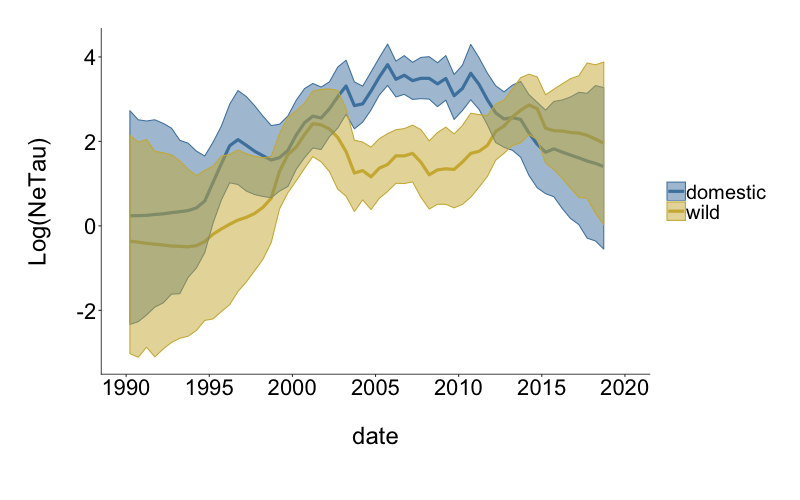

In [61]:
%%R -w 800 -h 500 -u px -i current_date,label,Ne_summary,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("NeTau-log-",label,"-",current_date,".pdf", sep="")

Ne_summary$interval = as.numeric(Ne_summary$interval)

# optionally, remove human 
Ne_summary <- Ne_summary[!(Ne_summary$deme=="human"),]

p <- ggplot(data=Ne_summary, aes(x=date, y=mean_Ne_log,group=deme, color=deme, fill=deme)) + 
    geom_line(size=1.5)+
    geom_ribbon(data=Ne_summary, aes(x=date, ymin = lower_hpd_log, ymax = upper_hpd_log,fill = Ne_summary$deme,group=Ne_summary$deme), alpha=0.5) +
    #geom_density(data=mig_df_melted, aes(x=value, group=variable, color=variable, fill=variable), trim=TRUE, alpha=0.6, linetype="solid",size=1)+
    labs(x="\ndate\n",y="Log(NeTau)\n")+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, p, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

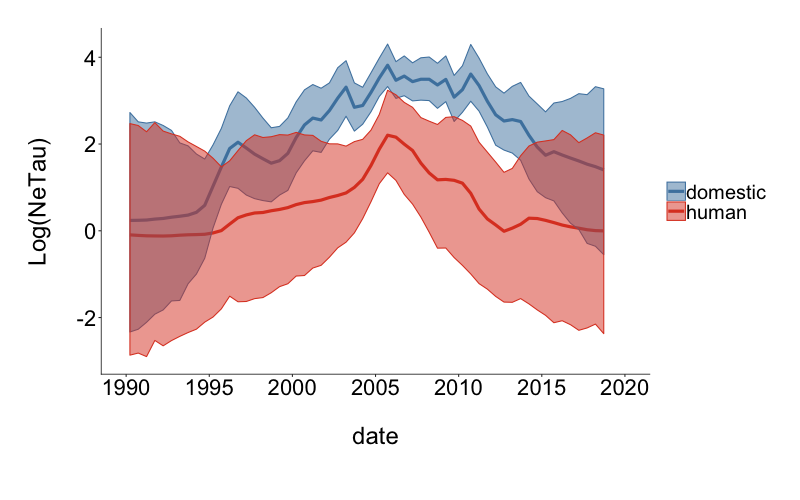

In [62]:
%%R -w 800 -h 500 -u px -i current_date,label,Ne_summary,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("NeTau-log-2-",label,"-",current_date,".pdf", sep="")

Ne_summary$interval = as.numeric(Ne_summary$interval)

# optionally, remove wild
Ne_summary <- Ne_summary[!(Ne_summary$deme=="wild"),]

p <- ggplot(data=Ne_summary, aes(x=date, y=mean_Ne_log,group=deme, color=deme, fill=deme)) + 
    geom_line(size=1.5)+
    geom_ribbon(data=Ne_summary, aes(x=date, ymin = lower_hpd_log, ymax = upper_hpd_log,fill = Ne_summary$deme,group=Ne_summary$deme), alpha=0.5) +
    #geom_density(data=mig_df_melted, aes(x=value, group=variable, color=variable, fill=variable), trim=TRUE, alpha=0.6, linetype="solid",size=1)+
    labs(x="\ndate\n",y="Log(NeTau)\n")+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

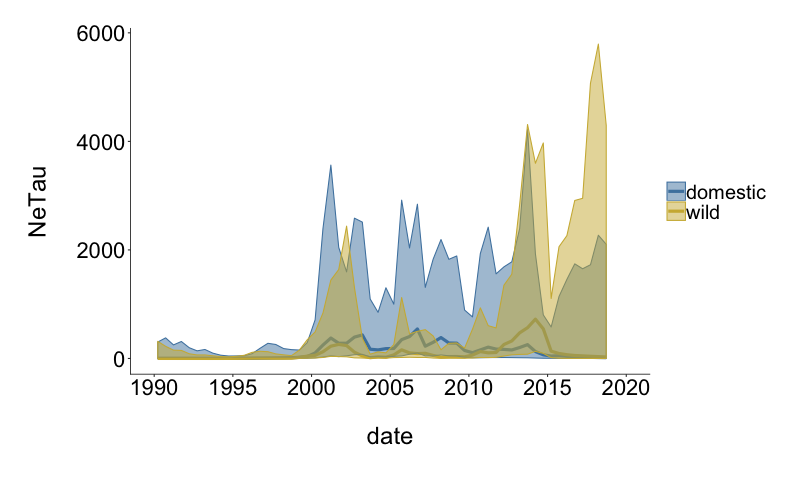

In [176]:
%%R -w 800 -h 500 -u px -i current_date,label,Ne_summary,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("NeTau-linear-",label,"-",current_date,".pdf", sep="")

Ne_summary$interval = as.numeric(Ne_summary$interval)

# optionally, remove human 
Ne_summary <- Ne_summary[!(Ne_summary$deme=="human"),]

p <- ggplot(data=Ne_summary, aes(x=date, y=mean_Ne_linear,group=deme, color=deme, fill=deme)) + 
    geom_line(size=1.5)+
    geom_ribbon(data=Ne_summary, aes(x=date, ymin = lower_hpd_linear, ymax = upper_hpd_linear,fill = Ne_summary$deme,group=Ne_summary$deme), alpha=0.5) +
    #geom_density(data=mig_df_melted, aes(x=value, group=variable, color=variable, fill=variable), trim=TRUE, alpha=0.6, linetype="solid",size=1)+
    labs(x="\ndate\n",y="NeTau\n")+
     scale_color_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
     scale_fill_manual(values=c(domestic=domestic_color,wild=wild_color,human=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    scale_x_continuous(breaks=seq(1990,2020,5), limits=c(1990,2020))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

In [47]:
def get_burnin_value(tree_path, burnin_percent):
    with open(tree_path, 'rU') as infile:
        numtrees = 0
        for line in infile: ## iterate through each line
            if 'state' in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                numtrees += 1
    
    burnin = numtrees * burnin_percent
    return(burnin)

In [140]:
all_trees = "beast-runs/2021-02-16-mascot-3deme/test.trees"
burnin_percent = 0.0

taxa_lines = get_taxa_lines(all_trees)
burnin = get_burnin_value(all_trees, burnin_percent)
print(burnin)

0.0


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 'U' mode is deprecated
  
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 'U' mode is deprecated
  


In [157]:
def return_persistence_times(tree, return_dict):
            
    for k in sorted(tree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k
        
        if 'max' in k.traits:
            host = k.traits['max']
        else:
            host = 'ancestor'
        
        if k.branchType == "node":
            children = k.children
            
            ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
            traverse_condition=lambda w:w.traits['max'].lower().replace()==kloc
            subtree=tree.subtree(k,traverse_condition=traverse_condition) 


In [158]:
hosts_dict = {'human':[],'domestic':[],'wild':[]}
return_persistence_times(tree, hosts_dict)

[<baltic.node object at 0x7fb1c3d19f28>, <baltic.node object at 0x7fb1c6c065f8>]
[<baltic.node object at 0x7fb1c3d19ef0>, <baltic.node object at 0x7fb1c6c062b0>]
[<baltic.node object at 0x7fb1dc6f1400>, <baltic.node object at 0x7fb1da3c4710>]
[<baltic.node object at 0x7fb1c3483470>, <baltic.node object at 0x7fb1dfd05630>]
[<baltic.node object at 0x7fb1c69f2f28>, <baltic.node object at 0x7fb1dfd05198>]
[<baltic.node object at 0x7fb1dacade80>, <baltic.node object at 0x7fb1c72317f0>]
[<baltic.node object at 0x7fb1c3670400>, <baltic.node object at 0x7fb1c7231ef0>]
[<baltic.leaf object at 0x7fb1c20c0f28>, <baltic.node object at 0x7fb1c72319b0>]
[<baltic.node object at 0x7fb1c2bdfb00>, <baltic.node object at 0x7fb1c3309eb8>]
[<baltic.node object at 0x7fb1c2e5ada0>, <baltic.node object at 0x7fb1c0484320>]
[<baltic.node object at 0x7fb1c698c160>, <baltic.node object at 0x7fb1c04841d0>]
[<baltic.node object at 0x7fb1c698cb70>, <baltic.node object at 0x7fb1c802add8>]
[<baltic.node object at 0x7f

In [ ]:
from io import StringIO
import time
start_time = time.time()

with open(all_trees, "r") as infile:
    
    tree_counter = 0
    
    for line in infile:
        if 'tree STATE_' in line:
            tree_counter += 1
            if tree_counter > burnin:
                temp_tree = StringIO(taxa_lines + line)
                tree = bt.loadNexus(temp_tree)
                print(tree)

                hosts_list = ['human','wild','domestic']
                subtype_trees = retrieve_subtrees(tree)
                cluster_times_dict = output_cluster_times(subtype_trees)
            
print("My program took", time.time() - start_time, "to run")